In [71]:
# import required packages
# source: https://www.kaggle.com/allunia/patterns-of-colorectal-cancer-wally

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='darkgrid')

# Import classifiers used:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier

# Data Transformation
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer


# Import ovo and ovr related stuff
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import VotingClassifier

# Pre-processing Data:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict, GridSearchCV, KFold

# Import Metrics
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, classification_report, multilabel_confusion_matrix, confusion_matrix, plot_confusion_matrix, plot_roc_curve

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Optimize HP
from evolutionary_search import EvolutionaryAlgorithmSearchCV

#Base Libraries
import random

# Custom Transformer for Y
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor

In [4]:
# Ensure that GPU is detected
assert(tf.config.experimental.list_physical_devices('GPU') is not None), 'GPU not detected'
print('GPU Detected. TF good to go')

GPU Detected. TF good to go


### Read Data from CSV File & Do Preprocessing required

In [5]:
df = pd.read_csv('../01_Data_Files/hmnist_64_64_L.csv', engine='c') # read 64x64 gray scale images as csv
dict_class_names = {1: 'Tumor', 2:'Stroma', 3:'Complex', 4:'Lymphoma', 5:'Debris', 6:'Mucosa', 7:'Adipose', 8:'Empty'}

# Adds a column with name of the label based on the integer value
df['label_name'] = df['label'].map(dict_class_names)

# 
class_names = ['Tumor', 'Stroma', 'Complex', 'Lymphoma', 'Debris', 'Mucosa', 'Adipose', 'Empty']

In [6]:
X = df.drop(['label', 'label_name'], axis=1).values
y = df.loc[:, 'label_name'].values.reshape(-1,1)

assert len(X) == len(y), 'X & y length mismatch'

### Use MinMax Scaler to scale the values of X from 0-255 to between 0 and 1. 

The min max scaler uses the following formula to calculate the scaled values:

$$ x^{\prime} = \frac{x-min(x)}{max(x)-min(x)}$$

In [7]:
# Scale Values of X via a MinMaxScaler
# We know that our input can vary between 0 and 255
min_max_scaler = MinMaxScaler()

# Create a fake array with values between 0 and 255 to use for fitting min max scaler
scaling_array = np.append(
    [np.zeros_like(X[0], dtype=np.int16)], [np.full_like(X[0], 255, dtype=np.int16)], axis=0
)
min_max_scaler.fit(scaling_array)
X_scaled = min_max_scaler.transform(X)

### One Hot Encode Y values for Tensorflow Usage & Label Encode for Sklearn Usage

To learn more about one hot encoding:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=one%20hot%20encode#sklearn.preprocessing.OneHotEncoder

To learn more about label encoding:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html?highlight=encoder#sklearn.preprocessing.LabelEncoder




In [64]:
# One Hot Encode y_values:
one_hot_encoder = OneHotEncoder(sparse=False)
y_one_hot = one_hot_encoder.fit_transform(y)
print('One Hot Encoded Y Shape: ', y_one_hot.shape)

# Label Encoding to conver String labels to integer labels:
label_encoder = LabelEncoder()
y_int_encode = label_encoder.fit_transform(y)
print(f'Label Encoded Y Shape: {y_int_encode.shape}, Max Value: {y_int_encode.max()}, Min Value: {y_int_encode.min()}')

One Hot Encoded Y Shape:  (5000, 8)
Label Encoded Y Shape: (5000,), Max Value: 7, Min Value: 0


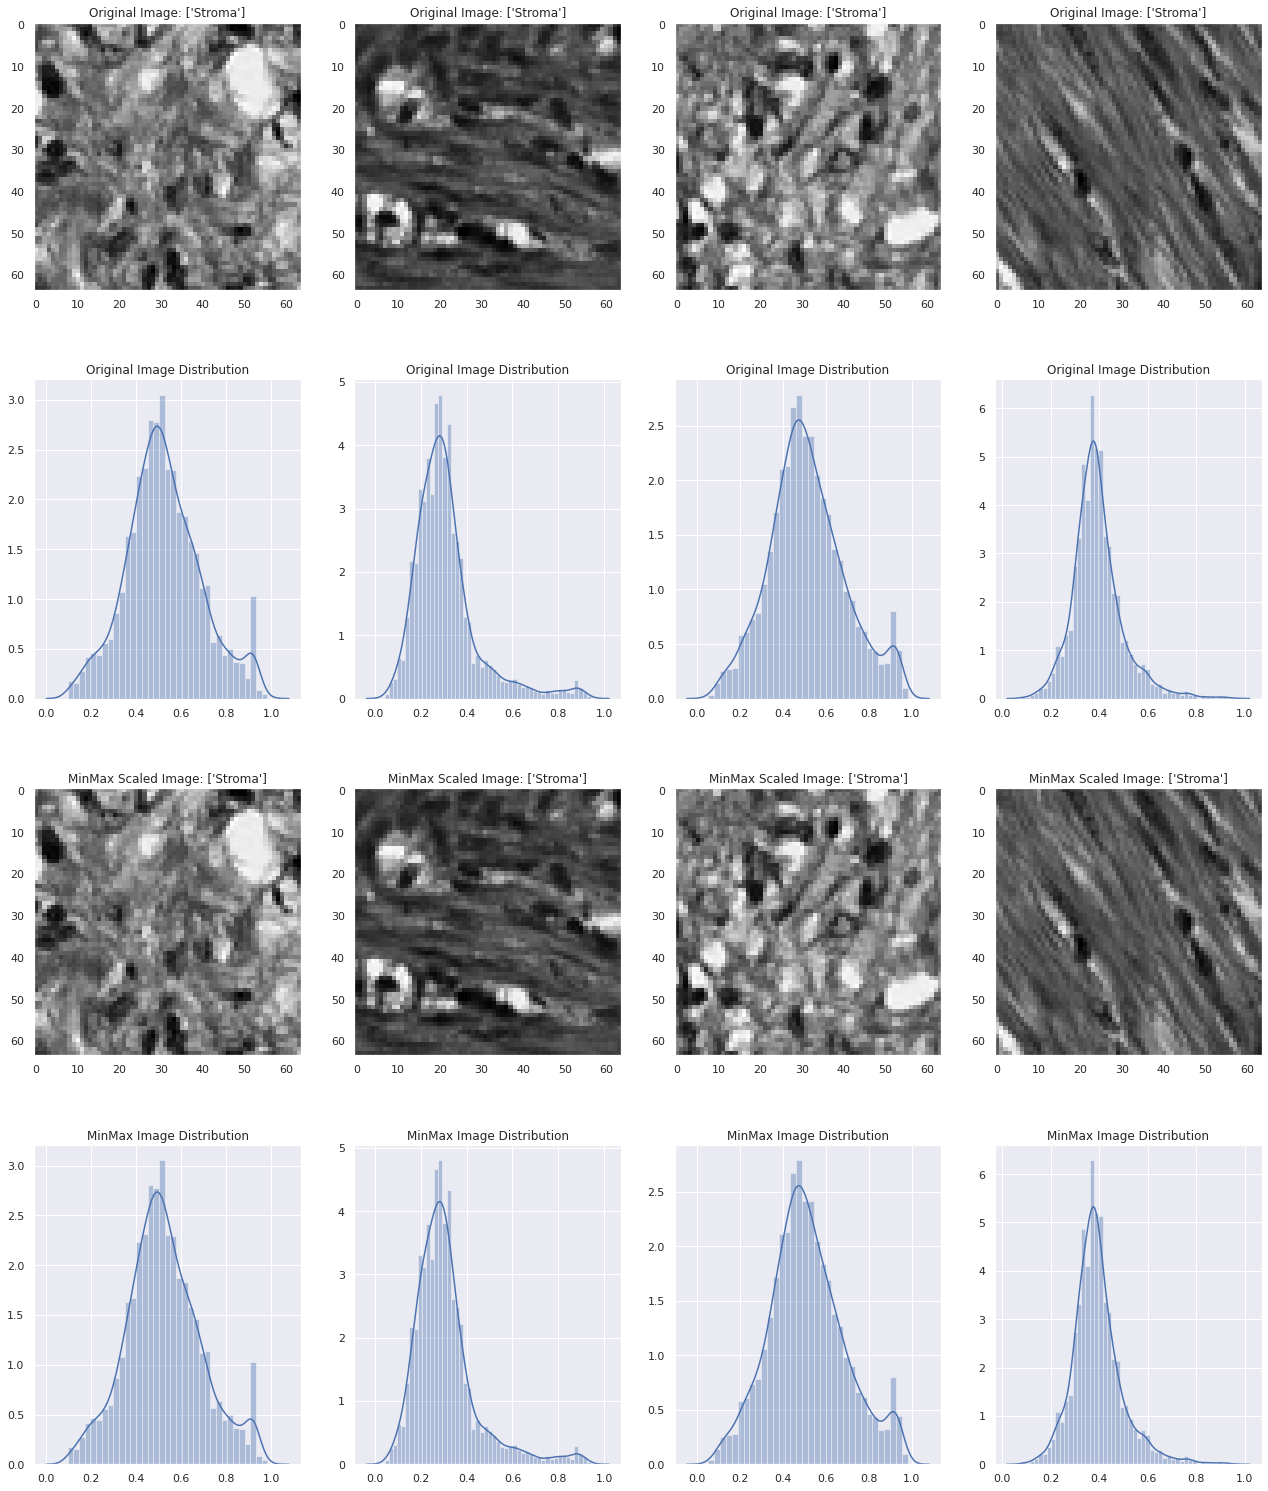

In [9]:
# Lets make sure that that distribution of our data hasn't changed significantly due to scaling. 
# Mostly a sanity check
fig, axs = plt.subplots(4, 4, figsize=(22,27))
for i in range(4):

    # Show Original Images
    original_image = np.reshape(X_scaled[i], (64,64))
    axs[0,i].imshow(original_image, cmap='gray')
    label_image = y[i]
    axs[0,i].set_title(f'Original Image: {label_image}')
    axs[0,i].grid(False)

    # Show histogram of values in image:
    sns.distplot(original_image, ax=axs[1,i])
    axs[1,i].set_title('Original Image Distribution')
    axs[1,i].set_ylabel('')

    # Show Scaled Images:
    scaled_image = np.reshape(X_scaled[i], (64,64))
    axs[2,i].imshow(scaled_image, cmap='gray')
    label_image = y[i]
    axs[2,i].set_title(f'MinMax Scaled Image: {label_image}')
    axs[2,i].grid(False)

    # Show histogram of values in image:
    sns.distplot(scaled_image, ax=axs[3,i])
    axs[3,i].set_title('MinMax Image Distribution')
    axs[3,i].set_ylabel('')

plt.savefig('Image Distributions.png')


### Setup Nested CV

Nested CV allows us to do both hyper parameter tuning and classifier performance comparision without producing an overly-optimistic score as in the case of non-nested CV. This happens when information leaks into the model since we use the same data to not only do hyper paramter tuning but also evaluation. 

We will use evolutionary algorithms to find the best parameters instead of relying on grid search. This is done in the interest of time. 

##### Parameters for each model:

Create a parameter grid for evolutionary search: 
The structure of the grid wil be: {clf_name:{param_name:value, param_name:value}, clf_name:{param_name:value...}}

Nested dictionaries!

In [10]:
# Convolutional Neural Network:
# Architecture: Input - Conv2D, Conv 2D, Conv2D, Flatten, Dense, Dense, Dense - Output
# Source: https://www.kaggle.com/efeergun96/colorectal-histology-prediction-by-cnn
def create_model(optimizer='Adam', ):
    model = Sequential()

    model.add(Reshape(
        target_shape= (64,64,1), 
        input_shape = (4096,),
    ))

    model.add(Conv2D(
        filters = 128, 
        kernel_size = (5,5), 
        padding = 'same',
        activation = 'relu' 
    ))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        activation='relu'
    ))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        activation='relu'
    ))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer = "Adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

    return model

In [61]:
param_grid = {}
param_grid['k_neighbors_clf'] = {'n_neighbors':np.linspace(3, 20, num=5,dtype=np.int),
                                'weights':['uniform', 'distance'],
                                'leaf_size': np.linspace(20,100, num=3, dtype=np.int),
                                'p':[1,2]}

param_grid['gaussianb_clf'] = {'var_smoothing':[1e-9]}
param_grid['svm_clf']  = {  'C'     : np.logspace(-5, 5, num=5, base=10),
                            'gamma' : np.logspace(-9, 9, num=5, base=10), 
                            'kernel': ['rbf', 'linear', 'poly'],
                            'random_state':[42],
                            'decision_function_shape':['ovr','ovo']}

param_grid['ada_clf'] = {   'n_estimators': np.linspace(20, 100, num=6, dtype=np.int),
                            'random_state':[42]}

param_grid['dummy_clf'] = {'strategy': ['stratified'],
                            'random_state':[42]}

# https://www.worldscientific.com/doi/10.1142/S0218001420510039
param_grid['cnn_clf'] = {  'optimizer':['rmsprop', 'adam'],
                            'batch_size':[5,10,20],
                            'epochs':[10,20,50],
                            'validation_split':[0.1]}

random.seed(42)

In [70]:
k_neighbors_clf = KNeighborsClassifier()
gaussianb_clf = GaussianNB()

svm_clf = svm.SVC()
ada_clf = AdaBoostClassifier()

# Used for a baseline. 
dummy_clf = DummyClassifier()

# cnn
cnn_clf = KerasClassifier(build_fn=create_model, verbose=2)

clfs = {
    # 'k_neighbors_clf' : k_neighbors_clf,
    # 'gaussianb_clf' : gaussianb_clf,
    # 'svm_clf' : svm_clf,
    # 'ada_clf' : ada_clf,
    # 'dummy_clf': dummy_clf,
    'cnn_clf':cnn_clf
}

In [30]:
# # Dictionary will contain scores for each of the 
# RANDOM_SEED = 42

# nested_scores = {}
# non_nested_scores = {}

# # Using F1-macro since we have a balanced data set. 
# # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

# for key, value in clfs.items():
#     print(f'Fitting and testing {key} classifier')
#     inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)
#     outer_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)

#     # Formats the label (y) as either integer encoding or one-hot encoding for non-cnn clfs 
#     # and cnn-clfs accordingly. 
#     y_current = y_one_hot if (key == 'cnn_clf') else y_int_encode

#     clf = EvolutionaryAlgorithmSearchCV(estimator=value, 
#                                         params=param_grid[key], 
#                                         scoring='f1_macro',
#                                         cv=inner_cv, 
#                                         n_jobs=6,
#                                         verbose=2,
#                                         population_size=20,
#                                         gene_mutation_prob=0.10,
#                                         tournament_size=3,
#                                         generations_number=5,
#                                         refit=True)

#     %time clf.fit(X_scaled, y_current)

#     print(f'Parameter Optimization Complete for {key}, best params: \n{clf.best_params_}')
#     non_nested_scores[key] = clf.best_score_

#     nested_scores[key] = cross_val_score(clf, 
#                                         X=X_scaled, 
#                                         y=y_current, 
#                                         cv=outer_cv, 
#                                         scoring='f1_macro', 
#                                         n_jobs=-1,
#                                         )

#     break

In [72]:
# Dictionary will contain scores for each of the 
RANDOM_SEED = 42

nested_scores = {}
non_nested_scores = {}

# Using F1-macro since we have a balanced data set. 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

for key, value in clfs.items():
    print(f'Fitting and testing {key} classifier')
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)
    outer_cv = KFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)

    # Formats the label (y) as either integer encoding or one-hot encoding for non-cnn clfs 
    # and cnn-clfs accordingly. 
    y_current = y_one_hot if (key == 'cnn_clf') else y_int_encode

    clf = GridSearchCV(estimator=value, 
                        param_grid=param_grid[key], 
                        scoring='f1_macro',
                        cv=inner_cv, 
                        n_jobs=-1,
                        verbose=2,
                        refit=True)

    %time clf.fit(X_scaled, y_current)

    print(f'Parameter Optimization Complete for {key}, best params: \n{clf.best_params_}')

    nested_scores[key] = cross_val_score(clf, 
                                        X=X_scaled, 
                                        y=y_current, 
                                        cv=outer_cv, 
                                        scoring='f1_macro', 
                                        n_jobs=-1,
                                        )

    break

Fitting and testing cnn_clf classifier
Fitting 2 folds for each of 18 candidates, totalling 36 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  36 | elapsed:    6.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    6.4s finished


InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [54]:
nested_scores

{'ada_clf': array([0.10504587, 0.11061236])}